# Meridional Heat Transport

We propose a "Two-Box" thought experiment.*What if we split the Earth into the Tropics and the Poles?* 

The 0-D Energy Balance Model ($E_{in} = E_{out}$) works well for the *entire* planet. But locally, the Earth is not in radiative balance. The equator receives much more solar energy than it radiates away, and the poles radiate away much more energy than they receive from the sun.

If there were no fluid envelopes (ocean and atmosphere) to move this heat, the tropics would boil and the poles would reach near absolute zero (like the Moon!). Because the Earth's climate is relatively stable, **there must be a massive transport of energy from the equator to the poles.**

### Objectives
Today, we will use satellite data to actually **calculate and plot this heat transport**. We will:
1. Compute the **Net Radiative Flux** at the Top of Atmosphere (TOA).
2. Visualize the energy surplus and deficit regions.
3. Use calculus (integration) over the sphere to deduce the implied **Meridional (North-South) Heat Transport** required to keep the climate stable.
4. Construct a discrete **Four-Box Model** to intuitively understand the transport across major climate boundaries.

*Note: This exercise is closely adapted from the Albany ATM623 course notes.*

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.integrate as integrate

# Constants for our physical calculations
a = 6.371e6 # Radius of the Earth in meters
PW = 1e15 # One Petawatt (10^15 Watts)

## The Net Radiation at Top of Atmosphere ($R_{TOA}$)

The net energy entering the Earth system at any point is the **Absorbed Solar Radiation (ASR)** minus the **Outgoing Longwave Radiation (OLR)**.

$$ R_{TOA} = ASR - OLR $$
$$ R_{TOA} = (SW_{in} - SW_{out}) - LW_{out} $$

In [2]:
# 1. Load the Datasets
ds_sw_in = xr.open_dataset('Datasets/CERES_TOA_IncomingSW.nc')
ds_sw_out = xr.open_dataset('Datasets/CERES_TOA_OutgoingSW.nc')
ds_olr = xr.open_dataset('Datasets/CERES_TOA_OutgoingLW.nc')

# 2. Calculate Time Averages (Climatological Mean)
sw_in = ds_sw_in.solar_mon.mean(dim='time')
sw_out = ds_sw_out.toa_sw_all_mon.mean(dim='time')
olr = ds_olr.toa_lw_all_mon.mean(dim='time')

# 3. Compute ASR and Net Radiation
asr = sw_in - sw_out
net_radiation = asr - olr

net_radiation.name = "Net_Radiation"

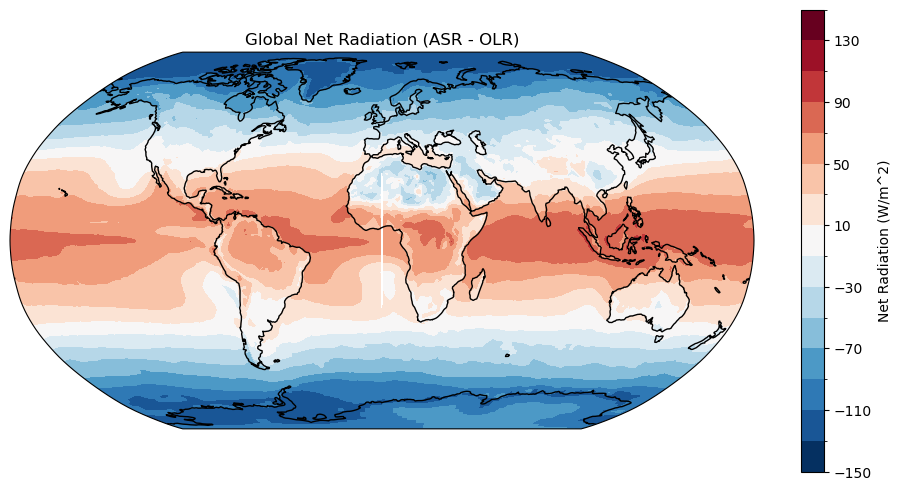

In [3]:
# Visualize the Net Radiation Map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

# We use a diverging colormap (RdBu_r) centered on zero
net_radiation.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                            levels=np.arange(-150, 160, 20), 
                            cmap='RdBu_r', 
                            cbar_kwargs={'label': 'Net Radiation (W/m^2)'})

ax.coastlines()
plt.title("Global Net Radiation (ASR - OLR)")
plt.show()

**Observation:** The deep red band at the equator shows a massive energy surplus (> 100 $W/m^2$). The deep blue at the poles shows a massive energy deficit. This map is the blueprint for global weather.

## The Zonal Mean Perspective

To simplify the problem, we average around latitude circles (Zonal Mean). This reduces our 2D map to a 1D graph of energy vs. latitude.

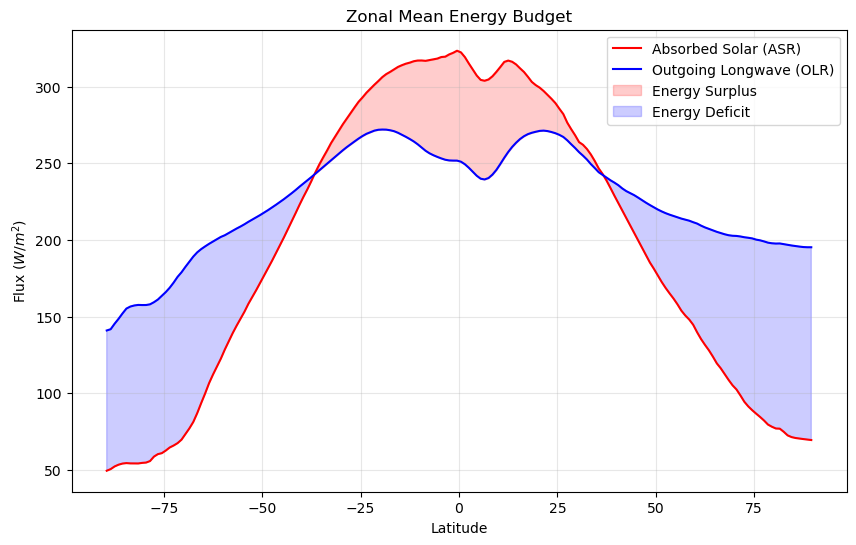

In [5]:
# Calculate Zonal Means (average over longitude)
asr_zonal = asr.mean(dim='lon')
olr_zonal = olr.mean(dim='lon')
net_zonal = net_radiation.mean(dim='lon')

# Plotting
plt.figure(figsize=(10, 6))
asr_zonal.plot(label='Absorbed Solar (ASR)', color='red')
olr_zonal.plot(label='Outgoing Longwave (OLR)', color='blue')

# Add a fill to highlight the surplus and deficit
plt.fill_between(asr_zonal.lat, asr_zonal, olr_zonal, where=(asr_zonal > olr_zonal), 
                 color='red', alpha=0.2, label='Energy Surplus')
plt.fill_between(asr_zonal.lat, asr_zonal, olr_zonal, where=(asr_zonal < olr_zonal), 
                 color='blue', alpha=0.2, label='Energy Deficit')

plt.title("Zonal Mean Energy Budget")
plt.ylabel("Flux ($W/m^2$)")
plt.xlabel("Latitude")
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

## The Physics of Heat Transport

How do we convert a local flux ($W/m^2$) into a global transport (Watts)?

Think of a latitude line $\phi$. The total heat crossing this line to the north ($H(\phi)$) must exactly equal the integral of the net radiation over the entire surface area of the Earth *south* of that latitude.

$$ H(\phi) = \int_{-\pi/2}^{\phi} \overline{R_{TOA}}(\phi') \times (\text{Circumference}) \times d\phi' $$

Using spherical geometry, the circumference of a latitude band is $2\pi a \cos(\phi)$, and the tiny width is $a\,d\phi$. Therefore, the area element is $2\pi a^2 \cos(\phi) \, d\phi$.

$$ H(\phi) = 2\pi a^2 \int_{-\pi/2}^{\phi} \overline{R_{TOA}}(\phi') \cos(\phi') d\phi' $$

### Real-World Correction
If the Earth were perfectly balanced, the integral from South Pole to North Pole would be exactly zero. However, satellite data often shows a slight global imbalance (e.g., ~1 $W/m^2$) due to ocean heat uptake (Global Warming) and instrument calibration. 

If we don't remove this, our transport at the North Pole won't go to zero! Let's subtract the global mean imbalance to ensure a closed budget.

In [6]:
# Calculate the Global Imbalance
weights = np.cos(np.deg2rad(net_zonal.lat))
global_imbalance = net_zonal.weighted(weights).mean().values
print(f"Global Mean Imbalance: {global_imbalance:.2f} W/m^2")

# Correct the Net Radiation by removing the global imbalance
net_zonal_corrected = net_zonal - global_imbalance

Global Mean Imbalance: 1.04 W/m^2


## Performing the Integration

Now we do the calculus. We will use `scipy.integrate.cumulative_trapezoid` to integrate from the South Pole (-90°) to the North Pole (+90°).

In [7]:
# Convert latitude to radians for the math
lat_rad = np.deg2rad(net_zonal.lat)

# Calculate the integrand: 2 * pi * a^2 * R_TOA * cos(lat)
integrand = 2 * np.pi * a**2 * net_zonal_corrected * np.cos(lat_rad)

# Perform the cumulative integration 
# (initial=0 ensures the array length matches our latitudes)
heat_transport = integrate.cumulative_trapezoid(integrand, lat_rad, initial=0)

# Convert from Watts to Petawatts (10^15 Watts)
heat_transport_pw = heat_transport / PW

# Add this back to an Xarray DataArray for easy plotting
H_phi = xr.DataArray(heat_transport_pw, coords=[net_zonal.lat], dims=['lat'])

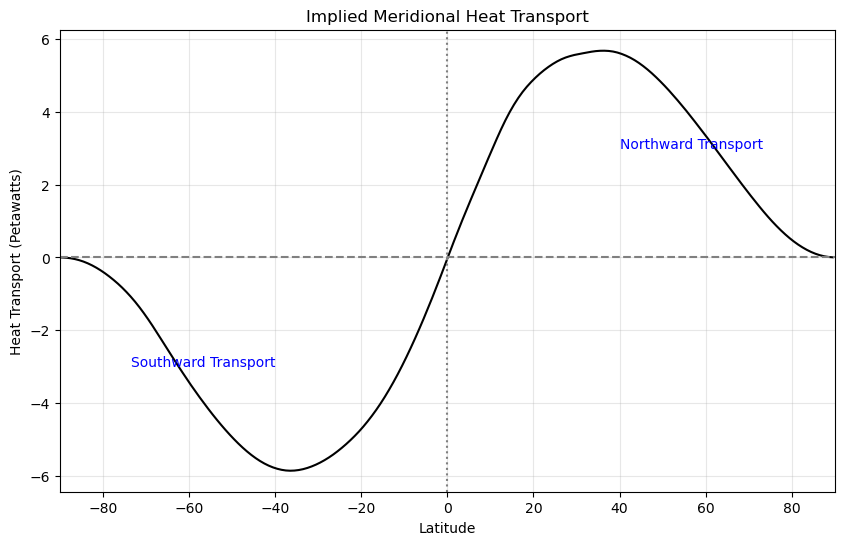

In [9]:
# Plot the Final Heat Transport
plt.figure(figsize=(10, 6))

H_phi.plot(color='black')

# Formatting the plot
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle=':')

plt.title("Implied Meridional Heat Transport")
plt.ylabel("Heat Transport (Petawatts)")
plt.xlabel("Latitude")
plt.grid(True, alpha = 0.3)
plt.xlim(-90, 90)

# Annotations
plt.text(40, 3, "Northward Transport", color='blue', horizontalalignment='left')
plt.text(-40, -3, "Southward Transport", color='blue', horizontalalignment='right')

plt.show()

## The Four-Box Model (Discrete Transport)

Instead of integrating point-by-point, what if we just split the Earth into **4 large boxes**?
1. **Southern Extratropics:** 90°S to 30°S
2. **Southern Tropics:** 30°S to Equator
3. **Northern Tropics:** Equator to 30°N
4. **Northern Extratropics:** 30°N to 90°N

We can calculate the average radiative balance ($W/m^2$) for each box, calculate its total area, and determine exactly how many Petawatts of energy each box is generating (or losing). Then, we can look at the boundaries to see how that energy is exported!

In [13]:
boxes = [(-90, -30), (-30, 0), (0, 30), (30, 90)]
box_names = ["Southern Extratropics", "Southern Tropics", "Northern Tropics", "Northern Extratropics"]

print("ENERGY BUDGET BY BOX")
print()
for i, (lat_min, lat_max) in enumerate(boxes):
    # Select the data for the specific box
    box_data = net_zonal_corrected.sel(lat=slice(lat_min, lat_max))
    
    # Calculate the area-weighted average flux (W/m^2)
    box_weights = np.cos(np.deg2rad(box_data.lat))
    avg_flux = box_data.weighted(box_weights).mean().values
    
    # Calculate the total surface area of this latitude band
    # Area = 2 * pi * R^2 * (sin(lat_max) - sin(lat_min))
    area = 2 * np.pi * a**2 * (np.sin(np.deg2rad(lat_max)) - np.sin(np.deg2rad(lat_min)))
    
    # Total Energy = Average Flux * Area (Convert to Petawatts)
    total_energy_pw = (avg_flux * area) / PW
    
    print(f"{box_names[i]} ({lat_min}° to {lat_max}°):")
    print(f"Average Flux: {avg_flux:6.2f} W/m^2")
    print(f"Total Energy: {total_energy_pw:6.2f} PW")
    print()


ENERGY BUDGET BY BOX

Southern Extratropics (-90° to -30°):
Average Flux: -44.45 W/m^2
Total Energy:  -5.67 PW

Southern Tropics (-30° to 0°):
Average Flux:  44.16 W/m^2
Total Energy:   5.63 PW

Northern Tropics (0° to 30°):
Average Flux:  44.03 W/m^2
Total Energy:   5.61 PW

Northern Extratropics (30° to 90°):
Average Flux: -43.74 W/m^2
Total Energy:  -5.58 PW



### Verifying the Boundaries

Look at the **Southern Extratropics**. It operates at a huge deficit (losing ~5-6 PW of energy). To maintain a stable temperature, the **Southern Tropics** must be exporting that exact amount of heat southward across the 30°S boundary!

Let's check our continuous `H_phi` calculation at these exact boundaries (-30°, 0°, and 30°) to see if it matches our box model intuition.

In [14]:
# Extract transport at the boundaries using our previously calculated H_phi array
transport_30S = H_phi.sel(lat=-30, method='nearest').values
transport_0 = H_phi.sel(lat=0, method='nearest').values
transport_30N = H_phi.sel(lat=30, method='nearest').values

print("IMPLIED BOUNDARY TRANSPORTS \n")
print(f"Across 30°S boundary: {transport_30S:5.2f} PW")

print(f"Across the Equator: {transport_0:5.2f} PW")

print(f"Across 30°N boundary: {transport_30N:5.2f} PW")

IMPLIED BOUNDARY TRANSPORTS 

Across 30°S boundary: -5.64 PW
Across the Equator:  0.12 PW
Across 30°N boundary:  5.59 PW


## Conclusion and Interpretation

**Direction:** 
   * In the Northern Hemisphere, the value is positive, meaning heat flows **North** (from Equator to North Pole).
   * In the Southern Hemisphere, the value is negative, meaning heat flows **South** (from Equator to South Pole).
   * *In both cases, heat flows away from the hot equator to extratropics.* 

**The Maximum Transport:**
   * The peak transport occurs right around **35° to 40° latitude**, exactly where our ASR and OLR lines crossed in Step 2. 
   * The total transport peaks at roughly **5 to 6 Petawatts**. To put that in perspective, total human energy consumption is about 0.018 Petawatts. The Earth's fluid envelope moves hundreds of times more energy than human civilization uses, continuously.